In [1]:
import pickle
import random
from os.path import join

#from copy import deepcopy, copy
#from indra.statements import pretty_print_stmts as pps
from collections import defaultdict, Counter
import texttable
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.metrics import roc_curve, auc, classification_report, \
                            precision_recall_curve, matthews_corrcoef

from indra.tools import assemble_corpus as ac
from indra.belief import BeliefEngine, get_ev_for_stmts_from_supports
from indra.belief.skl import CountsScorer
from bioexp.util import format_axis, fontsize
from bioexp.curation.belief_models import OrigBeliefStmt, OrigBelief
from bioexp.curation.classifiers import BinaryRandomForest, LogLogisticRegression

# TEMP
from bioexp.curation.model_fit import ModelFit, ens_sample

%matplotlib notebook

In [2]:
# Load pickle of assembled statements.
all_stmts = ac.load_statements('../data/bioexp_asmb_preassembled.pkl')

INFO: [2023-01-22 17:58:14] indra.tools.assemble_corpus - Loading ../data/bioexp_asmb_preassembled.pkl...
INFO: [2023-01-22 17:59:17] indra.tools.assemble_corpus - Loaded 895580 statements


Make a dictionary so we can retrieve statements by their hash, and define some other useful variables:

In [3]:
stmts_by_hash = {s.get_hash(): s for s in all_stmts}

reader_list = ['reach', 'sparser', 'medscan', 'rlimsp', 'trips']

opath = '../output/'
prefix = 'fig4_ipynb'

def fig_path(name, fmt):
    return join(opath, f'{prefix}_{name}.{fmt}')

In [4]:
# Filter out statements with None agents and those with only DB support.
reader_stmts = []
for stmt in tqdm(all_stmts):
    if None in stmt.agent_list():
        continue
    if not set([ev.source_api for ev in stmt.evidence]).intersection(set(reader_list)):
        pass
    else:
        reader_stmts.append(stmt)

100%|██████████| 895580/895580 [00:03<00:00, 296018.43it/s]


Load the curated data:

In [5]:
curation_data_file = '../data/curation/extended_curation_dataset.pkl'

def load_curation_data(filename):
    with open(filename, 'rb') as f:
        dataset = pickle.load(f)
        df = pd.DataFrame.from_records(dataset)
        df = df.fillna(0)
    # Every column except agent names and stmt type should be int
    dtype_dict = {col: 'int64' for col in df.columns
                  if col not in ('agA_name', 'agA_ns', 'agA_id', 'stmt_type',
                                 'agB_name', 'agB_ns', 'agB_id')}
    df = df.astype(dtype_dict)
    return df

cur_df = load_curation_data(curation_data_file)

How many records in the dataset?

In [6]:
cur_df.shape

(1689, 32)

Get a list of all the curated statements:

In [7]:
# Get dataset of curated statements along with correctness values
def stmts_for_df(df, stmts_by_hash):
    stmt_list = []
    for row in df.itertuples():
        stmt_hash = row.stmt_hash
        stmt_list.append(stmts_by_hash[stmt_hash])
    return stmt_list

cur_stmts = stmts_for_df(cur_df, stmts_by_hash)

## Code for fitting models

List all the source APIs for curated statements:

In [8]:
all_sources = list(set([ev.source_api for stmt in cur_stmts for ev in stmt.evidence]))
all_sources

['hprd',
 'rlimsp',
 'bel',
 'trips',
 'reach',
 'biopax',
 'sparser',
 'medscan',
 'isi',
 'trrust',
 'signor']

Define classes for storing the results of training and testing models. `TrainTestResult` Records the predictions, probabilities, RO curve, PR curve, etc. for a single fold of the data. `ModelResult` aggregates the `TrainTestResult` objects for all of the folds.

In [9]:
class TrainTestResult:
    def __init__(self, y_preds, y_probs, y_test, base_fpr, sample_wts):
        self.y_preds = y_preds
        self.y_probs = y_probs      
        self.y_test = y_test
        self.sample_wts = sample_wts

        # Get and store true/false positive rates and thresholds for ROC curve
        self.fpr, self.tpr, self.thresholds = roc_curve(y_test, y_probs[:, 1],
                                                        sample_weight=self.sample_wts)
        # Calculate ROC AUC
        self.roc_auc = auc(self.fpr, self.tpr)
        # Get TPR interpolated to base_fpr
        self.tpr_interp = np.interp(base_fpr, self.fpr, self.tpr)
        self.tpr_interp[0] = 0.0
        # Precision/recall/thresholds for each model
        self.precision, self.recall, self.thresholds = \
                    precision_recall_curve(y_test, y_probs[:, 1], sample_weight=self.sample_wts)
        self.pr_auc = auc(self.recall, self.precision)
        #pr_auc_arr[fold_ix] = pr_auc
        self.prec_interp = np.interp(base_fpr, self.thresholds, self.precision[:-1])
        #prec_arr[fold_ix, :] = interp(base_fpr, thresholds, precision[:-1])
        self.rec_interp = np.interp(base_fpr, self.thresholds, self.recall[:-1])
        self.mcc = matthews_corrcoef(y_test, y_preds, sample_weight=self.sample_wts)

class ModelResults:
    def __init__(self, clf_name, feat_set_name, feat_kwargs, base_fpr):
        # True positives
        self.base_fpr = base_fpr
        self.clf_name = clf_name
        self.feat_set_name = feat_set_name
        self.feat_kwargs = feat_kwargs
        self.tt_results = []
        
    def add_result(self, tt_result):
        self.tt_results.append(tt_result)

    def get_summary(self):
        clf_results = [{'y_preds': tt.y_preds,
                        'y_probs': tt.y_probs,
                        'y_test': tt.y_test} for tt in self.tt_results]
        # Combine get matrices with all TPR, Precision and Recall results
        dim = (len(self.tt_results), len(self.base_fpr))
        tpr_arr = np.zeros(dim)
        prec_arr = np.zeros(dim)
        rec_arr = np.zeros(dim)
        for ix, ttr in enumerate(self.tt_results):
            tpr_arr[ix, :] = ttr.tpr_interp
            prec_arr[ix, :] = ttr.prec_interp
            rec_arr[ix, :] = ttr.rec_interp
        return {
         'clf': clf_results,
         'mcc': np.array([ttr.mcc for ttr in self.tt_results]),
         'roc': tpr_arr.mean(axis=0),
         'roc_auc': np.array([ttr.roc_auc for ttr in self.tt_results]),
         'prec': prec_arr.mean(axis=0),
         'rec': rec_arr.mean(axis=0),
         'pr_auc': np.array([ttr.pr_auc for ttr in self.tt_results]),
         'x_interp': self.base_fpr}
    
def shuffle_train_df(df, stmts_by_hash, seed=1):
    """Given dataframe, return shuffled stmts and y_arr."""
    stmts = stmts_for_df(df, stmts_by_hash)
    y_arr = df['correct'].values
    return shuffle_train_stmts(stmts, y_arr, seed)

def shuffle_train_stmts(stmts, y_arr, seed=1):
    """Return training data as a shuffled list of statements
    and corresponding correctness values."""
    random.seed(seed)
    stmt_y_pairs = list(zip(stmts, y_arr))
    random.shuffle(stmt_y_pairs)
    stmts, y_vals = list(zip(*stmt_y_pairs))
    return stmts, np.array(y_vals)    

Given a dictionary of models and a dataset, the function eval_models_relation:
* Filters the dataset columns to only the given readers, and filters the rows to only those where there is evidence from those readers (i.e., so all databases are excluded)
* Defines a set of different statement features to use
* Splits the dataset into test and train using StratifiedKFold
* Trains and tests all models, for all feature sets, for all folds

In [47]:
# Train and evaluate a set of models
def eval_models_relation(model_dict, predictors, df, readers, split_func, num_folds=10,
                         cols_to_include=None, seed=1, include_more_specific=False,
                        use_weights=False,):
    # Filter to columns where at least one of the readers has an entry
    # Exclude
    cols_to_drop = [col for col in df.columns if col not in readers + ['stmt_hash', 'correct']]
    df = df.drop(cols_to_drop, axis=1)
    df = df[df[readers].any(1)]
    print("Readers", str(readers), "Num_rows", len(df), "Pct corr", df['correct'].mean())

    # The baseline y-axis for ROC and PRC plots
    base_fpr = np.linspace(0, 1, 101)    
    # Shuffle the data
    stmts, y_arr = shuffle_train_df(df, stmts_by_hash, seed=seed)
    # Get split points
    skf = StratifiedKFold(num_folds, shuffle=False)
    skf.split(stmts, y_arr)
    # Dict to save results
    model_results = {}    
    # For every fold...
    for fold_ix, (train_ix, test_ix) in tqdm(enumerate(skf.split(stmts, y_arr))):
        # ...try every classifier
        for clf_name, clf in model_dict.items():
            # ...with different sets of features (predictors):
            for feat_set_name, feat_kwargs in predictors.items():
                if clf_name == 'Belief Orig' and feat_set_name == '+ Type/#PMIDs':
                    continue
                # Create a CountsModel for this type of classifier
                model = CountsScorer(clf, readers, include_more_specific, **feat_kwargs)
                # Identifier for this model type
                model_key = '%s %s' % (clf_name, feat_set_name)
                # If necessary, instantiate the ModelResults object to
                # save train/test results
                if model_key not in model_results:
                    model_results[model_key] = ModelResults(clf_name, feat_set_name, feat_kwargs, base_fpr)
                # Use instance of CountsModel to get feature data as a matrix
                # with appropriate featurization
                # Split the preprocessed data matrix according to the split points
                x_train_stmts = [stmts[i] for i in train_ix]
                x_test_stmts = [stmts[i] for i in test_ix]
                y_train = y_arr[train_ix]
                y_test = y_arr[test_ix]
                # Train the model
                if include_more_specific:
                    train_evidences = get_ev_for_stmts_from_supports(x_train_stmts)
                else:
                    train_evidences = None
                if use_weights:
                    train_wts = [s.weight for s in x_train_stmts]
                    test_wts = [s.weight for s in x_test_stmts]
                    model.fit(x_train_stmts, y_train, extra_evidence=train_evidences, sample_weight=train_wts)
                else:
                    test_wts = None
                    model.fit(x_train_stmts, y_train, extra_evidence=train_evidences)
                # Make predictions for the test set
                if include_more_specific:
                    test_evidences = get_ev_for_stmts_from_supports(x_test_stmts)
                else:
                    test_evidences = None
                y_preds = model.predict(x_test_stmts, extra_evidence=test_evidences)
                y_probs = model.predict_proba(x_test_stmts, extra_evidence=test_evidences)
                # Save results in TrainTestResult object
                tt_result = TrainTestResult(y_preds, y_probs, y_test, base_fpr, test_wts)
                # Add to the model results for this model type
                model_results[model_key].add_result(tt_result)
    return model_results

Functions to plot ROC and PRC curves, averaged across folds:

In [11]:
# Functions to plot mean ROC and AUPRC from k-fold cross-validation
def plot_roc(results):
    fig = plt.figure(figsize=(2.0, 2.0), dpi=200)
    ax = plt.gca()
    lw = 0.5
    colors = ['r', 'g', 'b', 'orange', 'k', 'y', 'c', 'm']
    colors = colors + colors
    # Plot ROC curve for Belief Model (REACH)
    #plt.plot(bel_fpr, bel_tpr, color=colors[0],
    #         lw=lw, label='Orig. Belief (area = %0.2f)' % bel_roc_auc)
    #roc_results = results['roc']
    #roc_auc = results['roc_auc']
    for i, (clf_name, mr_obj) in enumerate(results.items()):
        mr_dict = mr_obj.get_summary()
        roc_auc_arr = mr_dict['roc_auc']
        plt.plot(mr_dict['x_interp'], mr_dict['roc'], color=colors[i],
             lw=lw, label='%s (area = %0.3f +/- %0.3f)' %
                          (clf_name, roc_auc_arr.mean(), roc_auc_arr.std() / np.sqrt(len(roc_auc_arr))))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.01])
    plt.ylim([0.0, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic', fontsize=6)
    plt.legend(loc="lower right", fontsize=4, frameon=False)
    format_axis(ax)
    
    plt.subplots_adjust(left=0.15)
    return fig

# Function to plot mean precision-recall curve from k-fold cross validation
def plot_prc(results):
    fig = plt.figure(figsize=(2.0, 2.0), dpi=200)
    ax = plt.gca()
    lw = 0.5
    colors = ['r', 'g', 'b', 'orange', 'k', 'y', 'c', 'm']
    colors = colors + colors
    for i, (clf_name, mr_obj) in enumerate(results.items()):
        mr_dict = mr_obj.get_summary()
        prec_arr = mr_dict['prec']
        rec_arr = mr_dict['rec']
        pr_auc = mr_dict['pr_auc']                                   
        plt.plot(rec_arr, prec_arr, color=colors[i],
             lw=lw, label='%s (area = %0.3f +/- %0.3f)' %
                          (clf_name, pr_auc.mean(), pr_auc.std() / np.sqrt(len(pr_auc))))
    plt.xlim([0.0, 1.01])
    plt.ylim([0.0, 1.01])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    fontsize=6
    plt.title('Precision-Recall Curve', fontsize=6)
    plt.legend(loc="lower left", fontsize=4, frameon=False)
    format_axis(ax)
    return fig

# Function to plot mean precision-recall curve from k-fold cross validation
def plot_calibration(results):
    fig = plt.figure(figsize=(2.0, 2.0), dpi=200)
    ax = plt.gca()
    lw = 0.5
    colors = ['r', 'g', 'b', 'orange', 'k', 'y', 'c', 'm']
    colors = colors + colors
    for i, (clf_name, mr_obj) in enumerate(results.items()):
        mr_dict = mr_obj.get_summary()
        prec_arr = mr_dict['prec']
        #rec_arr = mr_dict['rec']
        #pr_auc = mr_dict['pr_auc']                                   
        plt.plot(mr_obj.base_fpr, prec_arr, color=colors[i],
             lw=lw, label='%s' % clf_name)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.01])
    plt.ylim([0.0, 1.01])
    plt.xlabel('Threshold')
    plt.ylabel('Precision')
    fontsize=6
    plt.title('Precision/Threshold Curve', fontsize=6)
    plt.legend(loc="lower left", fontsize=4, frameon=False)
    format_axis(ax)
    return fig

## Comparing different classifiers 

In [48]:
class OrigBeliefStmtSkl(OrigBeliefStmt):
    def __init__(self, weights=None):
        # Modify constructor to make sure weights are not optional
        super().__init__(weights)

    def log_likelihood_stmt(self, params, data, args):
        pr, ps = params
        ll = 0
        if self.weights is not None and \
           (len(self.weights) != len(correct_by_num_ev)):
            raise ValueError("Weight vector must correspond to the stmt data.")
        for ix, (num_ev, correct) in enumerate(data):
            ll_n = 0
            if correct == 0:
                ll_n += np.log(1 - self.belief(num_ev, pr, ps))
            else:
                ll_n += np.log(self.belief(num_ev, pr, ps))
            if self.weights:
                ll += self.weights[ix] * ll_n
            else:
                ll += ll_n            
        return ll

class BeliefModel(object):
    """Wrapper of belief models implementing sklearn classifier interface.

    reader_list : list
        List of sources.
    model_class : class or None
        One of the belief models in bioexp.curation.belief_models. If not
        provided, OrigBeliefStmt (original two-parameter Belief Model) is
        used.
    nwalkers : int
        Number of MCMC walkers.
    burn_steps : int
        Number of MCMC burn-in steps.
    sample_steps : int
        Number of MCMC sampling steps.
    """
    def __init__(self, reader_list, model_class=None, nwalkers=100,
                  burn_steps=100, sample_steps=100, use_supports=False):
        if model_class is None:
            model_class = OrigBeliefStmt
        self.reader_list = reader_list
        self.model_class = model_class
        self.nwalkers = nwalkers
        self.burn_steps = burn_steps
        self.sample_steps = sample_steps
        self.use_supports = use_supports
        self.reader_results = {}

    @staticmethod
    def df_to_tuples(df):
        tlist = []
        for _, num_ev, correct in df.itertuples():
            tlist.append((num_ev, correct))
        return tlist
    
    def fit(self, x_train, y_train, y_target=1, sample_weight=None):
        # The first len(reader_list) columns in x_train will be the direct evidences,
        # the next will be the indirect (supports) evidences. We split the matrix and
        # add to get the right number of evidences for calibration
        # THIS SECTION IS FOR THE BRANCH WITH SUPP EVIDENCE
        # -----
        if self.use_supports:
            dir_ev = x_train[:, 0:len(self.reader_list)]
            indir_ev = x_train[:, len(self.reader_list):(2*len(self.reader_list))]
            total_ev = dir_ev + indir_ev
            data = np.column_stack([total_ev, y_train])
        else:
            dir_ev = x_train[:, 0:len(self.reader_list)]
            data = np.column_stack([dir_ev, y_train])
        self.y_ix = data.shape[1]-1
        self.y_target = y_target
        cols = self.reader_list + ['correct']
        df = pd.DataFrame(data, columns=cols)
        # Get the unique input vectors in x_train
        for reader in self.reader_list:
            r_df = df[df[reader] > 0][[reader, 'correct']]
            data = self.df_to_tuples(r_df)
            # Convert the dataframe into a dictionary of corrects and
            # incorrects keyed by numbers of evidences
            print(reader, r_df.shape)
            model = OrigBeliefStmtSkl(weights=sample_weight)                                
            mf = ModelFit(model, data, flat_data=True)
            pool = None
            sampler = ens_sample(mf, self.nwalkers, self.burn_steps,
                                     self.sample_steps, pool=pool)
            self.reader_results[reader] = (mf, sampler)

    def predict_proba(self, x_arr):
        y_probs = np.zeros((x_arr.shape[0], 2))
        reader_errs = np.zeros((x_arr.shape[0], len(self.reader_list)))
        for ix, reader in enumerate(self.reader_list):
            x_data = x_arr[:, ix]
            mf, sampler = self.reader_results[reader]
            map_params_dict = mf.get_map_params(sampler)
            params = [map_params_dict[pname] for pname in mf.model.param_names]
            reader_errs[:, ix] = mf.model.stmt_predictions(params, x_data)
        err_probs = 1 - reader_errs
        y_probs[:, 0] = err_probs.prod(axis=1)
        y_probs[:, 1] = 1 - y_probs[:, 0]
        return y_probs

    def predict(self, x_arr, threshold=0.5):
        y_preds = np.zeros(x_arr.shape[0])
        y_probs = self.predict_proba(x_arr)
        for row_ix, pred_prob in enumerate(y_probs):
            if pred_prob[1] is np.nan:
                pred = np.nan
            else:
                pred = 0 if pred_prob[1] < threshold else 1
            y_preds[row_ix] = pred
        return y_preds

## Model comparison 

In [13]:
seed = 4

### ML Models

In [14]:
source_list = reader_list

#train_df = kge_df[reader_list + ['correct']]
models_ev = {
    'Log LR': LogLogisticRegression(solver='liblinear'),    
    'SVC': SVC(probability=True),
    'KNN': KNeighborsClassifier(),
    'RF 2k-d13': RandomForestClassifier(n_estimators=2000, max_depth=13),
}
# Predictors
predictors = {'': {'use_stmt_type': False, 'use_num_members': False}, #'All features': x,
              '+ Type/#PMIDs': {'use_stmt_type': True, 'use_num_pmids': True},   
             }

no_wt = eval_models_relation(models_ev, predictors, cur_df, source_list, None,
                              num_folds=10, cols_to_include=None, seed=seed)

0it [00:00, ?it/s]INFO: [2023-01-22 17:59:37] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 17:59:37] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 17:59:37] indra.belief.skl - source_list does not include all source_apis in the statement data.


Readers ['reach', 'sparser', 'medscan', 'rlimsp', 'trips'] Num_rows 1676 Pct corr 0.7374701670644391


INFO: [2023-01-22 17:59:37] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 17:59:37] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 17:59:37] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 17:59:38] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 17:59:38] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 17:59:38] indra.belief.skl - source_list does not include all source_apis in the statement data.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
INFO: [2023-01-22 17:59:38] indra.belief.skl - source_list does not include all sour

INFO: [2023-01-22 17:59:56] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 17:59:56] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 17:59:56] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 17:59:57] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:00:00] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:00:00] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:00:00] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:00:03] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:00:03] indra.belief.skl - source_list does not include all 

INFO: [2023-01-22 18:00:22] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:00:22] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:00:22] indra.belief.skl - source_list does not include all source_apis in the statement data.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
INFO: [2023-01-22 18:00:22] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:00:22] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:00:22] indra.belief.skl - source_list does not include all source_apis in the statement data.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklear

INFO: [2023-01-22 18:00:40] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:00:43] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:00:44] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:00:44] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:00:47] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:00:47] indra.belief.skl - source_list does not include all source_apis in the statement data.
8it [01:10,  8.77s/it]INFO: [2023-01-22 18:00:48] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:00:48] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:00:48] indra.belief.skl - source_list

In [15]:
# ---------------------------------
# Predictors
source_list = reader_list
predictors = {'+ Type/#PMIDs/avglen': {'use_stmt_type': True, 'use_num_pmids': True,
                                       'use_avg_evidence_len': True}, 
              '+ Type/#PMIDs/promoter': {'use_stmt_type': True, 'use_num_pmids': True, 'use_promoter': True},   
              '+ Type/#PMIDs/prom/avglen': {'use_stmt_type': True, 'use_num_pmids': True,
                                            'use_promoter': True, 'use_avg_evidence_len': True},   
             }              
              
models_ev = {
    'Log LR': LogLogisticRegression(solver='liblinear'),    
    'RF 2k-d13': RandomForestClassifier(n_estimators=2000, max_depth=13),
}
              
no_wt_more_feats = eval_models_relation(models_ev, predictors, cur_df, source_list, None,
                                        num_folds=10, cols_to_include=None, seed=seed)

0it [00:00, ?it/s]INFO: [2023-01-22 18:01:05] indra.belief.skl - source_list does not include all source_apis in the statement data.


Readers ['reach', 'sparser', 'medscan', 'rlimsp', 'trips'] Num_rows 1676 Pct corr 0.7374701670644391


INFO: [2023-01-22 18:01:05] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:01:05] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:01:05] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:01:05] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:01:05] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:01:06] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:01:06] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:01:06] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:01:06] indra.belief.skl - source_list does not include all 

4it [00:49, 12.28s/it]INFO: [2023-01-22 18:01:54] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:01:54] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:01:54] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:01:54] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:01:54] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:01:54] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:01:55] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:01:55] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:01:55] indra.belief.skl - source_list

INFO: [2023-01-22 18:02:42] indra.belief.skl - source_list does not include all source_apis in the statement data.
8it [01:37, 12.04s/it]INFO: [2023-01-22 18:02:42] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:02:43] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:02:43] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:02:43] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:02:43] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:02:43] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:02:43] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:02:43] indra.belief.skl - source_list

In [16]:
# --------------------------------------
source_list = reader_list

# Predictors
predictors = {'': {'use_stmt_type': False, 'use_num_members': False}, #'All features': x,
              '+ Type/#PMIDs': {'use_stmt_type': True, 'use_num_pmids': True},   
             }
 

models_ev = {
    'Log LR': LogLogisticRegression(solver='liblinear'),    
    'SVC': SVC(probability=True),
    'KNN': KNeighborsClassifier(),
    'RF 2k-d13': RandomForestClassifier(n_estimators=2000, max_depth=13),
    #'Belief Orig': BeliefModel(reader_list, use_supports=True),
}
supp_no_wt = eval_models_relation(models_ev, predictors, cur_df, source_list, None,
                              num_folds=10, cols_to_include=None, seed=seed, include_more_specific=True,
                              use_weights=False)

0it [00:00, ?it/s]INFO: [2023-01-22 18:03:06] indra.belief.skl - source_list does not include all source_apis in the statement data.


Readers ['reach', 'sparser', 'medscan', 'rlimsp', 'trips'] Num_rows 1676 Pct corr 0.7374701670644391


INFO: [2023-01-22 18:03:06] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:03:06] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:03:06] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:03:06] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:03:06] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:03:06] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:03:07] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:03:07] indra.belief.skl - source_list does not include all source_apis in the statement data.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sk

INFO: [2023-01-22 18:03:28] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:03:28] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:03:28] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:03:28] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:03:28] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:03:28] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:03:31] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:03:32] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:03:32] indra.belief.skl - source_list does not include all 

INFO: [2023-01-22 18:03:55] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:03:55] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:03:55] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:03:55] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:03:55] indra.belief.skl - source_list does not include all source_apis in the statement data.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
INFO: [2023-01-22 18:03:56] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:03:56] indra.belief.skl - source_list does not include all sour

INFO: [2023-01-22 18:04:16] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:04:16] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:04:16] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:04:19] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:04:19] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:04:19] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:04:23] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:04:23] indra.belief.skl - source_list does not include all source_apis in the statement data.
8it [01:17,  9.65s/it]INFO: [2023-01-22 18:04:23] indra.belief.skl - source_list

In [17]:
# --------------------------------------
source_list = reader_list

# Predictors
predictors = {'+ Type/#PMIDs/avglen': {'use_stmt_type': True, 'use_num_pmids': True,
                                       'use_avg_evidence_len': True}, 
              '+ Type/#PMIDs/promoter': {'use_stmt_type': True, 'use_num_pmids': True, 'use_promoter': True},   
              '+ Type/#PMIDs/prom/avglen': {'use_stmt_type': True, 'use_num_pmids': True,
                                            'use_promoter': True, 'use_avg_evidence_len': True},   
             }              
              
models_ev = {
    'Log LR': LogLogisticRegression(solver='liblinear'),    
    'RF 2k-d13': RandomForestClassifier(n_estimators=2000, max_depth=13),
}
              
supp_no_wt_more_feats = eval_models_relation(models_ev, predictors, cur_df, source_list, None,
                                        num_folds=10, cols_to_include=None, seed=seed,
                                        include_more_specific=True, use_weights=False)

0it [00:00, ?it/s]

Readers ['reach', 'sparser', 'medscan', 'rlimsp', 'trips'] Num_rows 1676 Pct corr 0.7374701670644391


INFO: [2023-01-22 18:04:43] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:04:43] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:04:43] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:04:43] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:04:43] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:04:43] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:04:43] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:04:44] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:04:44] indra.belief.skl - source_list does not include all 

INFO: [2023-01-22 18:05:30] indra.belief.skl - source_list does not include all source_apis in the statement data.
4it [00:47, 11.97s/it]INFO: [2023-01-22 18:05:31] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:05:31] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:05:31] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:05:31] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:05:31] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:05:31] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:05:31] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:05:31] indra.belief.skl - source_list

INFO: [2023-01-22 18:06:19] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:06:19] indra.belief.skl - source_list does not include all source_apis in the statement data.
8it [01:36, 12.08s/it]INFO: [2023-01-22 18:06:19] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:06:19] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:06:19] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:06:20] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:06:20] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:06:20] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:06:20] indra.belief.skl - source_list

As above, but with DBs:

In [18]:
source_list = all_sources

#train_df = kge_df[reader_list + ['correct']]
models_ev = {
    'Log LR': LogLogisticRegression(solver='liblinear'),    
    'SVC': SVC(probability=True),
    'KNN': KNeighborsClassifier(),
    'RF 2k-d13': RandomForestClassifier(n_estimators=2000, max_depth=13),
}
# Predictors
predictors = {'': {'use_stmt_type': False, 'use_num_members': False}, #'All features': x,
              '+ Type/#PMIDs': {'use_stmt_type': True, 'use_num_pmids': True},   
             }

no_wt_dbs = eval_models_relation(models_ev, predictors, cur_df, source_list, None,
                              num_folds=10, cols_to_include=None, seed=seed)

# ---------------------------------
# Predictors
predictors = {'+ Type/#PMIDs/avglen': {'use_stmt_type': True, 'use_num_pmids': True,
                                       'use_avg_evidence_len': True}, 
              '+ Type/#PMIDs/promoter': {'use_stmt_type': True, 'use_num_pmids': True, 'use_promoter': True},   
              '+ Type/#PMIDs/prom/avglen': {'use_stmt_type': True, 'use_num_pmids': True,
                                            'use_promoter': True, 'use_avg_evidence_len': True},   
             }              
              
models_ev = {
    'Log LR': LogLogisticRegression(solver='liblinear'),    
    'RF 2k-d13': RandomForestClassifier(n_estimators=2000, max_depth=13),
}
              
no_wt_more_feats_dbs = eval_models_relation(models_ev, predictors, cur_df, source_list, None,
                                        num_folds=10, cols_to_include=None, seed=seed)

# --------------------------------------

# Predictors
predictors = {'': {'use_stmt_type': False, 'use_num_members': False}, #'All features': x,
              '+ Type/#PMIDs': {'use_stmt_type': True, 'use_num_pmids': True},   
             }
 

models_ev = {
    'Log LR': LogLogisticRegression(solver='liblinear'),    
    'SVC': SVC(probability=True),
    'KNN': KNeighborsClassifier(),
    'RF 2k-d13': RandomForestClassifier(n_estimators=2000, max_depth=13),
    #'Belief Orig': BeliefModel(reader_list, use_supports=True),
}
supp_no_wt_dbs = eval_models_relation(models_ev, predictors, cur_df, source_list, None,
                              num_folds=10, cols_to_include=None, seed=seed, include_more_specific=True,
                                      use_weights=False)

# --------------------------------------

# Predictors
predictors = {'+ Type/#PMIDs/avglen': {'use_stmt_type': True, 'use_num_pmids': True,
                                       'use_avg_evidence_len': True}, 
              '+ Type/#PMIDs/promoter': {'use_stmt_type': True, 'use_num_pmids': True, 'use_promoter': True},   
              '+ Type/#PMIDs/prom/avglen': {'use_stmt_type': True, 'use_num_pmids': True,
                                            'use_promoter': True, 'use_avg_evidence_len': True},   
             }              
              
models_ev = {
    'Log LR': LogLogisticRegression(solver='liblinear'),    
    'RF 2k-d13': RandomForestClassifier(n_estimators=2000, max_depth=13),
}
              
supp_no_wt_more_feats_dbs = eval_models_relation(models_ev, predictors, cur_df, source_list, None,
                                        num_folds=10, cols_to_include=None, seed=seed,
                                        include_more_specific=True, use_weights=False)

0it [00:00, ?it/s]

Readers ['hprd', 'rlimsp', 'bel', 'trips', 'reach', 'biopax', 'sparser', 'medscan', 'isi', 'trrust', 'signor'] Num_rows 1689 Pct corr 0.7323860272350503


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
1it [00:08,  8.41s/it]/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
2it [00:17,  8.54s/it]/Library/Frameworks/Python.framework/Versions/3.7/li

Readers ['hprd', 'rlimsp', 'bel', 'trips', 'reach', 'biopax', 'sparser', 'medscan', 'isi', 'trrust', 'signor'] Num_rows 1689 Pct corr 0.7323860272350503


10it [01:55, 11.54s/it]
0it [00:00, ?it/s]

Readers ['hprd', 'rlimsp', 'bel', 'trips', 'reach', 'biopax', 'sparser', 'medscan', 'isi', 'trrust', 'signor'] Num_rows 1689 Pct corr 0.7323860272350503


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
1it [00:09,  9.40s/it]/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
2it [00:18,  9.37s/it]/Library/Frameworks/Python.framework/Versions/3.7/li

Readers ['hprd', 'rlimsp', 'bel', 'trips', 'reach', 'biopax', 'sparser', 'medscan', 'isi', 'trrust', 'signor'] Num_rows 1689 Pct corr 0.7323860272350503


10it [02:02, 12.29s/it]


Plot precision-recall curves:

<IPython.core.display.Javascript object>


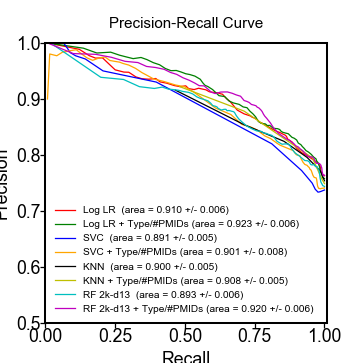

(0.5, 1)

In [19]:
fig = plot_prc(no_wt)
ax = fig.gca()
ax.set_ylim([0.5, 1])

<IPython.core.display.Javascript object>


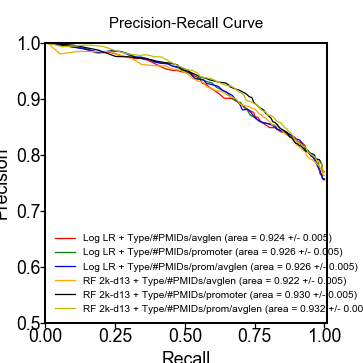

(0.5, 1)

In [20]:
fig = plot_prc(no_wt_more_feats)
ax = fig.gca()
ax.set_ylim([0.5, 1])

<IPython.core.display.Javascript object>


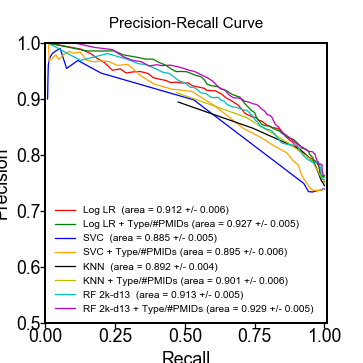

(0.5, 1)

In [21]:
fig = plot_prc(supp_no_wt)
ax = fig.gca()
ax.set_ylim([0.5, 1])

<IPython.core.display.Javascript object>


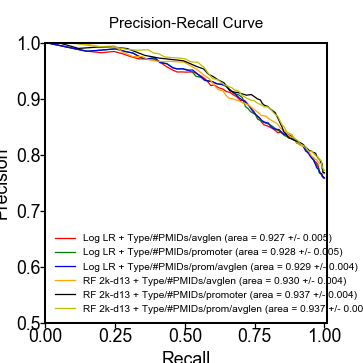

(0.5, 1)

In [22]:
fig = plot_prc(supp_no_wt_more_feats)
ax = fig.gca()
ax.set_ylim([0.5, 1])

### Belief model runs:

Each of the following cells takes about 30 minutes to run.

In [23]:
source_list = reader_list

# Predictors
predictors = {'': {'use_stmt_type': False, 'use_num_members': False}}

models_ev = {
    'Belief Orig': BeliefModel(reader_list, use_supports=False),
}

no_wt_bel = eval_models_relation(models_ev, predictors, cur_df, source_list, None,
                                 num_folds=10, cols_to_include=None, seed=seed)

0it [00:00, ?it/s]INFO: [2023-01-22 18:13:49] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:13:49] numexpr.utils - Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO: [2023-01-22 18:13:49] numexpr.utils - NumExpr defaulting to 8 threads.
INFO: [2023-01-22 18:13:49] model_fit - Burn in sampling...


Readers ['reach', 'sparser', 'medscan', 'rlimsp', 'trips'] Num_rows 1676 Pct corr 0.7374701670644391
reach (1066, 2)


INFO: [2023-01-22 18:14:18] model_fit - Main sampling...
INFO: [2023-01-22 18:14:47] model_fit - Done sampling.
INFO: [2023-01-22 18:14:47] model_fit - Burn in sampling...


sparser (855, 2)


INFO: [2023-01-22 18:15:10] model_fit - Main sampling...
INFO: [2023-01-22 18:15:33] model_fit - Done sampling.
INFO: [2023-01-22 18:15:33] model_fit - Burn in sampling...


medscan (844, 2)


INFO: [2023-01-22 18:15:55] model_fit - Main sampling...
INFO: [2023-01-22 18:16:17] model_fit - Done sampling.
INFO: [2023-01-22 18:16:17] model_fit - Burn in sampling...


rlimsp (249, 2)


INFO: [2023-01-22 18:16:23] model_fit - Main sampling...
INFO: [2023-01-22 18:16:29] model_fit - Done sampling.
INFO: [2023-01-22 18:16:29] model_fit - Burn in sampling...


trips (413, 2)


INFO: [2023-01-22 18:16:39] model_fit - Main sampling...
INFO: [2023-01-22 18:16:50] model_fit - Done sampling.
INFO: [2023-01-22 18:16:50] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:16:50] indra.belief.skl - source_list does not include all source_apis in the statement data.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
1it [03:00, 180.94s/it]INFO: [2023-01-22 18:16:50] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:16:50] model_fit - Burn in sampling...


reach (1069, 2)


INFO: [2023-01-22 18:17:18] model_fit - Main sampling...
INFO: [2023-01-22 18:17:47] model_fit - Done sampling.
INFO: [2023-01-22 18:17:47] model_fit - Burn in sampling...


sparser (860, 2)


INFO: [2023-01-22 18:18:09] model_fit - Main sampling...
INFO: [2023-01-22 18:18:32] model_fit - Done sampling.
INFO: [2023-01-22 18:18:32] model_fit - Burn in sampling...


medscan (844, 2)


INFO: [2023-01-22 18:18:54] model_fit - Main sampling...
INFO: [2023-01-22 18:19:16] model_fit - Done sampling.
INFO: [2023-01-22 18:19:16] model_fit - Burn in sampling...


rlimsp (235, 2)


INFO: [2023-01-22 18:19:22] model_fit - Main sampling...
INFO: [2023-01-22 18:19:28] model_fit - Done sampling.
INFO: [2023-01-22 18:19:28] model_fit - Burn in sampling...


trips (422, 2)


INFO: [2023-01-22 18:19:38] model_fit - Main sampling...
INFO: [2023-01-22 18:19:49] model_fit - Done sampling.
INFO: [2023-01-22 18:19:49] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:19:49] indra.belief.skl - source_list does not include all source_apis in the statement data.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
2it [05:59, 180.37s/it]INFO: [2023-01-22 18:19:49] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:19:49] model_fit - Burn in sampling...


reach (1070, 2)


INFO: [2023-01-22 18:20:17] model_fit - Main sampling...
INFO: [2023-01-22 18:20:47] model_fit - Done sampling.
INFO: [2023-01-22 18:20:47] model_fit - Burn in sampling...


sparser (847, 2)


INFO: [2023-01-22 18:21:09] model_fit - Main sampling...
INFO: [2023-01-22 18:21:31] model_fit - Done sampling.
INFO: [2023-01-22 18:21:31] model_fit - Burn in sampling...


medscan (834, 2)


INFO: [2023-01-22 18:21:52] model_fit - Main sampling...
INFO: [2023-01-22 18:22:14] model_fit - Done sampling.
INFO: [2023-01-22 18:22:14] model_fit - Burn in sampling...


rlimsp (237, 2)


INFO: [2023-01-22 18:22:20] model_fit - Main sampling...
INFO: [2023-01-22 18:22:26] model_fit - Done sampling.
INFO: [2023-01-22 18:22:26] model_fit - Burn in sampling...


trips (403, 2)


INFO: [2023-01-22 18:22:36] model_fit - Main sampling...
INFO: [2023-01-22 18:22:46] model_fit - Done sampling.
INFO: [2023-01-22 18:22:46] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:22:46] indra.belief.skl - source_list does not include all source_apis in the statement data.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
3it [08:57, 179.40s/it]INFO: [2023-01-22 18:22:46] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:22:46] model_fit - Burn in sampling...


reach (1063, 2)


INFO: [2023-01-22 18:23:15] model_fit - Main sampling...
INFO: [2023-01-22 18:23:44] model_fit - Done sampling.
INFO: [2023-01-22 18:23:44] model_fit - Burn in sampling...


sparser (853, 2)


INFO: [2023-01-22 18:24:07] model_fit - Main sampling...
INFO: [2023-01-22 18:24:31] model_fit - Done sampling.
INFO: [2023-01-22 18:24:31] model_fit - Burn in sampling...


medscan (851, 2)


INFO: [2023-01-22 18:24:52] model_fit - Main sampling...
INFO: [2023-01-22 18:25:15] model_fit - Done sampling.
INFO: [2023-01-22 18:25:15] model_fit - Burn in sampling...


rlimsp (234, 2)


INFO: [2023-01-22 18:25:20] model_fit - Main sampling...
INFO: [2023-01-22 18:25:26] model_fit - Done sampling.
INFO: [2023-01-22 18:25:26] model_fit - Burn in sampling...


trips (409, 2)


INFO: [2023-01-22 18:25:36] model_fit - Main sampling...
INFO: [2023-01-22 18:25:47] model_fit - Done sampling.
INFO: [2023-01-22 18:25:47] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:25:47] indra.belief.skl - source_list does not include all source_apis in the statement data.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
4it [11:57, 179.81s/it]INFO: [2023-01-22 18:25:47] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:25:47] model_fit - Burn in sampling...


reach (1057, 2)


INFO: [2023-01-22 18:26:16] model_fit - Main sampling...
INFO: [2023-01-22 18:26:46] model_fit - Done sampling.
INFO: [2023-01-22 18:26:46] model_fit - Burn in sampling...


sparser (853, 2)


INFO: [2023-01-22 18:27:09] model_fit - Main sampling...
INFO: [2023-01-22 18:27:34] model_fit - Done sampling.
INFO: [2023-01-22 18:27:34] model_fit - Burn in sampling...


medscan (842, 2)


INFO: [2023-01-22 18:27:56] model_fit - Main sampling...
INFO: [2023-01-22 18:28:19] model_fit - Done sampling.
INFO: [2023-01-22 18:28:19] model_fit - Burn in sampling...


rlimsp (234, 2)


INFO: [2023-01-22 18:28:25] model_fit - Main sampling...
INFO: [2023-01-22 18:28:30] model_fit - Done sampling.
INFO: [2023-01-22 18:28:30] model_fit - Burn in sampling...


trips (406, 2)


INFO: [2023-01-22 18:28:41] model_fit - Main sampling...
INFO: [2023-01-22 18:28:52] model_fit - Done sampling.
INFO: [2023-01-22 18:28:52] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:28:52] indra.belief.skl - source_list does not include all source_apis in the statement data.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
5it [15:02, 181.22s/it]INFO: [2023-01-22 18:28:52] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:28:52] model_fit - Burn in sampling...


reach (1058, 2)


INFO: [2023-01-22 18:29:20] model_fit - Main sampling...
INFO: [2023-01-22 18:29:49] model_fit - Done sampling.
INFO: [2023-01-22 18:29:49] model_fit - Burn in sampling...


sparser (851, 2)


INFO: [2023-01-22 18:30:12] model_fit - Main sampling...
INFO: [2023-01-22 18:30:35] model_fit - Done sampling.
INFO: [2023-01-22 18:30:35] model_fit - Burn in sampling...


medscan (837, 2)


INFO: [2023-01-22 18:30:57] model_fit - Main sampling...
INFO: [2023-01-22 18:31:19] model_fit - Done sampling.
INFO: [2023-01-22 18:31:19] model_fit - Burn in sampling...


rlimsp (239, 2)


INFO: [2023-01-22 18:31:25] model_fit - Main sampling...
INFO: [2023-01-22 18:31:31] model_fit - Done sampling.
INFO: [2023-01-22 18:31:31] model_fit - Burn in sampling...


trips (420, 2)


INFO: [2023-01-22 18:31:41] model_fit - Main sampling...
INFO: [2023-01-22 18:31:52] model_fit - Done sampling.
INFO: [2023-01-22 18:31:52] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:31:52] indra.belief.skl - source_list does not include all source_apis in the statement data.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
6it [18:03, 181.13s/it]INFO: [2023-01-22 18:31:53] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:31:53] model_fit - Burn in sampling...


reach (1063, 2)


INFO: [2023-01-22 18:32:20] model_fit - Main sampling...
INFO: [2023-01-22 18:32:51] model_fit - Done sampling.
INFO: [2023-01-22 18:32:51] model_fit - Burn in sampling...


sparser (862, 2)


INFO: [2023-01-22 18:33:13] model_fit - Main sampling...
INFO: [2023-01-22 18:33:37] model_fit - Done sampling.
INFO: [2023-01-22 18:33:37] model_fit - Burn in sampling...


medscan (850, 2)


INFO: [2023-01-22 18:34:00] model_fit - Main sampling...
INFO: [2023-01-22 18:34:23] model_fit - Done sampling.
INFO: [2023-01-22 18:34:23] model_fit - Burn in sampling...


rlimsp (235, 2)


INFO: [2023-01-22 18:34:29] model_fit - Main sampling...
INFO: [2023-01-22 18:34:35] model_fit - Done sampling.
INFO: [2023-01-22 18:34:35] model_fit - Burn in sampling...


trips (413, 2)


INFO: [2023-01-22 18:34:45] model_fit - Main sampling...
INFO: [2023-01-22 18:34:56] model_fit - Done sampling.
INFO: [2023-01-22 18:34:56] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:34:56] indra.belief.skl - source_list does not include all source_apis in the statement data.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
7it [21:06, 181.85s/it]INFO: [2023-01-22 18:34:56] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:34:56] model_fit - Burn in sampling...


reach (1064, 2)


INFO: [2023-01-22 18:35:25] model_fit - Main sampling...
INFO: [2023-01-22 18:35:54] model_fit - Done sampling.
INFO: [2023-01-22 18:35:54] model_fit - Burn in sampling...


sparser (869, 2)


INFO: [2023-01-22 18:36:17] model_fit - Main sampling...
INFO: [2023-01-22 18:36:40] model_fit - Done sampling.
INFO: [2023-01-22 18:36:40] model_fit - Burn in sampling...


medscan (827, 2)


INFO: [2023-01-22 18:37:01] model_fit - Main sampling...
INFO: [2023-01-22 18:37:23] model_fit - Done sampling.
INFO: [2023-01-22 18:37:23] model_fit - Burn in sampling...


rlimsp (244, 2)


INFO: [2023-01-22 18:37:30] model_fit - Main sampling...
INFO: [2023-01-22 18:37:36] model_fit - Done sampling.
INFO: [2023-01-22 18:37:36] model_fit - Burn in sampling...


trips (410, 2)


INFO: [2023-01-22 18:37:46] model_fit - Main sampling...
INFO: [2023-01-22 18:37:57] model_fit - Done sampling.
INFO: [2023-01-22 18:37:57] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:37:57] indra.belief.skl - source_list does not include all source_apis in the statement data.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
8it [24:07, 181.64s/it]INFO: [2023-01-22 18:37:57] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:37:57] model_fit - Burn in sampling...


reach (1069, 2)


INFO: [2023-01-22 18:38:26] model_fit - Main sampling...
INFO: [2023-01-22 18:38:56] model_fit - Done sampling.
INFO: [2023-01-22 18:38:56] model_fit - Burn in sampling...


sparser (865, 2)


INFO: [2023-01-22 18:39:19] model_fit - Main sampling...
INFO: [2023-01-22 18:39:44] model_fit - Done sampling.
INFO: [2023-01-22 18:39:44] model_fit - Burn in sampling...


medscan (850, 2)


INFO: [2023-01-22 18:40:08] model_fit - Main sampling...
INFO: [2023-01-22 18:40:31] model_fit - Done sampling.
INFO: [2023-01-22 18:40:31] model_fit - Burn in sampling...


rlimsp (229, 2)


INFO: [2023-01-22 18:40:38] model_fit - Main sampling...
INFO: [2023-01-22 18:40:44] model_fit - Done sampling.
INFO: [2023-01-22 18:40:44] model_fit - Burn in sampling...


trips (416, 2)


INFO: [2023-01-22 18:40:55] model_fit - Main sampling...
INFO: [2023-01-22 18:41:06] model_fit - Done sampling.
INFO: [2023-01-22 18:41:06] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:41:06] indra.belief.skl - source_list does not include all source_apis in the statement data.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
9it [27:17, 183.88s/it]INFO: [2023-01-22 18:41:06] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:41:06] model_fit - Burn in sampling...


reach (1068, 2)


INFO: [2023-01-22 18:41:36] model_fit - Main sampling...
INFO: [2023-01-22 18:42:05] model_fit - Done sampling.
INFO: [2023-01-22 18:42:05] model_fit - Burn in sampling...


sparser (871, 2)


INFO: [2023-01-22 18:42:30] model_fit - Main sampling...
INFO: [2023-01-22 18:42:54] model_fit - Done sampling.
INFO: [2023-01-22 18:42:54] model_fit - Burn in sampling...


medscan (836, 2)


INFO: [2023-01-22 18:43:17] model_fit - Main sampling...
INFO: [2023-01-22 18:43:40] model_fit - Done sampling.
INFO: [2023-01-22 18:43:40] model_fit - Burn in sampling...


rlimsp (231, 2)


INFO: [2023-01-22 18:43:45] model_fit - Main sampling...
INFO: [2023-01-22 18:43:51] model_fit - Done sampling.
INFO: [2023-01-22 18:43:51] model_fit - Burn in sampling...


trips (401, 2)


INFO: [2023-01-22 18:44:01] model_fit - Main sampling...
INFO: [2023-01-22 18:44:12] model_fit - Done sampling.
INFO: [2023-01-22 18:44:12] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:44:12] indra.belief.skl - source_list does not include all source_apis in the statement data.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
10it [30:22, 182.27s/it]


TypeError: eval_models_relation() got an unexpected keyword argument 'use_supports_train'

In [32]:
source_list = reader_list

# Predictors
predictors = {'': {'use_stmt_type': False, 'use_num_members': False}}

# ---------------------------------
models_ev = {
    'Belief Orig': BeliefModel(reader_list, use_supports=True),
}

supp_no_wt_bel = eval_models_relation(
    models_ev, predictors, cur_df, source_list, None, num_folds=10,
    cols_to_include=None, seed=seed, include_more_specific=True, use_weights=False)

0it [00:00, ?it/s]

Readers ['reach', 'sparser', 'medscan', 'rlimsp', 'trips'] Num_rows 1676 Pct corr 0.7374701670644391


INFO: [2023-01-22 18:59:35] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 18:59:35] model_fit - Burn in sampling...


reach (1095, 2)


INFO: [2023-01-22 19:00:06] model_fit - Main sampling...
INFO: [2023-01-22 19:00:36] model_fit - Done sampling.
INFO: [2023-01-22 19:00:36] model_fit - Burn in sampling...


sparser (878, 2)


INFO: [2023-01-22 19:01:00] model_fit - Main sampling...
INFO: [2023-01-22 19:01:25] model_fit - Done sampling.
INFO: [2023-01-22 19:01:25] model_fit - Burn in sampling...


medscan (882, 2)


INFO: [2023-01-22 19:01:48] model_fit - Main sampling...
INFO: [2023-01-22 19:02:13] model_fit - Done sampling.
INFO: [2023-01-22 19:02:13] model_fit - Burn in sampling...


rlimsp (254, 2)


INFO: [2023-01-22 19:02:20] model_fit - Main sampling...
INFO: [2023-01-22 19:02:26] model_fit - Done sampling.
INFO: [2023-01-22 19:02:26] model_fit - Burn in sampling...


trips (425, 2)


INFO: [2023-01-22 19:02:37] model_fit - Main sampling...
INFO: [2023-01-22 19:02:48] model_fit - Done sampling.
INFO: [2023-01-22 19:02:48] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 19:02:48] indra.belief.skl - source_list does not include all source_apis in the statement data.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
1it [03:13, 193.32s/it]INFO: [2023-01-22 19:02:48] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 19:02:48] model_fit - Burn in sampling...


reach (1096, 2)


INFO: [2023-01-22 19:03:18] model_fit - Main sampling...
INFO: [2023-01-22 19:03:49] model_fit - Done sampling.
INFO: [2023-01-22 19:03:49] model_fit - Burn in sampling...


sparser (883, 2)


INFO: [2023-01-22 19:04:13] model_fit - Main sampling...
INFO: [2023-01-22 19:04:37] model_fit - Done sampling.
INFO: [2023-01-22 19:04:37] model_fit - Burn in sampling...


medscan (879, 2)


INFO: [2023-01-22 19:05:01] model_fit - Main sampling...
INFO: [2023-01-22 19:05:25] model_fit - Done sampling.
INFO: [2023-01-22 19:05:25] model_fit - Burn in sampling...


rlimsp (243, 2)


INFO: [2023-01-22 19:05:31] model_fit - Main sampling...
INFO: [2023-01-22 19:05:37] model_fit - Done sampling.
INFO: [2023-01-22 19:05:37] model_fit - Burn in sampling...


trips (431, 2)


INFO: [2023-01-22 19:05:49] model_fit - Main sampling...
INFO: [2023-01-22 19:06:00] model_fit - Done sampling.
INFO: [2023-01-22 19:06:00] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 19:06:00] indra.belief.skl - source_list does not include all source_apis in the statement data.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
2it [06:25, 192.86s/it]INFO: [2023-01-22 19:06:00] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 19:06:00] model_fit - Burn in sampling...


reach (1100, 2)


INFO: [2023-01-22 19:06:29] model_fit - Main sampling...
INFO: [2023-01-22 19:06:59] model_fit - Done sampling.
INFO: [2023-01-22 19:06:59] model_fit - Burn in sampling...


sparser (870, 2)


INFO: [2023-01-22 19:07:22] model_fit - Main sampling...
INFO: [2023-01-22 19:07:46] model_fit - Done sampling.
INFO: [2023-01-22 19:07:46] model_fit - Burn in sampling...


medscan (871, 2)


INFO: [2023-01-22 19:08:09] model_fit - Main sampling...
INFO: [2023-01-22 19:08:33] model_fit - Done sampling.
INFO: [2023-01-22 19:08:33] model_fit - Burn in sampling...


rlimsp (243, 2)


INFO: [2023-01-22 19:08:39] model_fit - Main sampling...
INFO: [2023-01-22 19:08:45] model_fit - Done sampling.
INFO: [2023-01-22 19:08:45] model_fit - Burn in sampling...


trips (415, 2)


INFO: [2023-01-22 19:08:55] model_fit - Main sampling...
INFO: [2023-01-22 19:09:06] model_fit - Done sampling.
INFO: [2023-01-22 19:09:06] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 19:09:06] indra.belief.skl - source_list does not include all source_apis in the statement data.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
3it [09:31, 190.95s/it]INFO: [2023-01-22 19:09:07] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 19:09:07] model_fit - Burn in sampling...


reach (1091, 2)


INFO: [2023-01-22 19:09:37] model_fit - Main sampling...
INFO: [2023-01-22 19:10:07] model_fit - Done sampling.
INFO: [2023-01-22 19:10:07] model_fit - Burn in sampling...


sparser (876, 2)


INFO: [2023-01-22 19:10:31] model_fit - Main sampling...
INFO: [2023-01-22 19:10:56] model_fit - Done sampling.
INFO: [2023-01-22 19:10:56] model_fit - Burn in sampling...


medscan (888, 2)


INFO: [2023-01-22 19:11:19] model_fit - Main sampling...
INFO: [2023-01-22 19:11:43] model_fit - Done sampling.
INFO: [2023-01-22 19:11:43] model_fit - Burn in sampling...


rlimsp (241, 2)


INFO: [2023-01-22 19:11:49] model_fit - Main sampling...
INFO: [2023-01-22 19:11:55] model_fit - Done sampling.
INFO: [2023-01-22 19:11:55] model_fit - Burn in sampling...


trips (420, 2)


INFO: [2023-01-22 19:12:06] model_fit - Main sampling...
INFO: [2023-01-22 19:12:17] model_fit - Done sampling.
INFO: [2023-01-22 19:12:17] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 19:12:17] indra.belief.skl - source_list does not include all source_apis in the statement data.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
4it [12:42, 190.85s/it]INFO: [2023-01-22 19:12:17] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 19:12:17] model_fit - Burn in sampling...


reach (1082, 2)


INFO: [2023-01-22 19:12:47] model_fit - Main sampling...
INFO: [2023-01-22 19:13:17] model_fit - Done sampling.
INFO: [2023-01-22 19:13:17] model_fit - Burn in sampling...


sparser (873, 2)


INFO: [2023-01-22 19:13:41] model_fit - Main sampling...
INFO: [2023-01-22 19:14:07] model_fit - Done sampling.
INFO: [2023-01-22 19:14:07] model_fit - Burn in sampling...


medscan (875, 2)


INFO: [2023-01-22 19:14:30] model_fit - Main sampling...
INFO: [2023-01-22 19:14:55] model_fit - Done sampling.
INFO: [2023-01-22 19:14:55] model_fit - Burn in sampling...


rlimsp (242, 2)


INFO: [2023-01-22 19:15:01] model_fit - Main sampling...
INFO: [2023-01-22 19:15:07] model_fit - Done sampling.
INFO: [2023-01-22 19:15:07] model_fit - Burn in sampling...


trips (415, 2)


INFO: [2023-01-22 19:15:18] model_fit - Main sampling...
INFO: [2023-01-22 19:15:29] model_fit - Done sampling.
INFO: [2023-01-22 19:15:29] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 19:15:29] indra.belief.skl - source_list does not include all source_apis in the statement data.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
5it [15:54, 191.13s/it]INFO: [2023-01-22 19:15:29] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 19:15:29] model_fit - Burn in sampling...


reach (1087, 2)


INFO: [2023-01-22 19:15:58] model_fit - Main sampling...
INFO: [2023-01-22 19:16:28] model_fit - Done sampling.
INFO: [2023-01-22 19:16:28] model_fit - Burn in sampling...


sparser (873, 2)


INFO: [2023-01-22 19:16:52] model_fit - Main sampling...
INFO: [2023-01-22 19:17:16] model_fit - Done sampling.
INFO: [2023-01-22 19:17:16] model_fit - Burn in sampling...


medscan (869, 2)


INFO: [2023-01-22 19:17:39] model_fit - Main sampling...
INFO: [2023-01-22 19:18:02] model_fit - Done sampling.
INFO: [2023-01-22 19:18:02] model_fit - Burn in sampling...


rlimsp (246, 2)


INFO: [2023-01-22 19:18:08] model_fit - Main sampling...
INFO: [2023-01-22 19:18:15] model_fit - Done sampling.
INFO: [2023-01-22 19:18:15] model_fit - Burn in sampling...


trips (430, 2)


INFO: [2023-01-22 19:18:25] model_fit - Main sampling...
INFO: [2023-01-22 19:18:36] model_fit - Done sampling.
INFO: [2023-01-22 19:18:36] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 19:18:36] indra.belief.skl - source_list does not include all source_apis in the statement data.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
6it [19:01, 190.08s/it]INFO: [2023-01-22 19:18:37] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 19:18:37] model_fit - Burn in sampling...


reach (1090, 2)


INFO: [2023-01-22 19:19:06] model_fit - Main sampling...
INFO: [2023-01-22 19:19:36] model_fit - Done sampling.
INFO: [2023-01-22 19:19:36] model_fit - Burn in sampling...


sparser (885, 2)


INFO: [2023-01-22 19:19:59] model_fit - Main sampling...
INFO: [2023-01-22 19:20:23] model_fit - Done sampling.
INFO: [2023-01-22 19:20:23] model_fit - Burn in sampling...


medscan (889, 2)


INFO: [2023-01-22 19:20:46] model_fit - Main sampling...
INFO: [2023-01-22 19:21:10] model_fit - Done sampling.
INFO: [2023-01-22 19:21:10] model_fit - Burn in sampling...


rlimsp (243, 2)


INFO: [2023-01-22 19:21:16] model_fit - Main sampling...
INFO: [2023-01-22 19:21:22] model_fit - Done sampling.
INFO: [2023-01-22 19:21:22] model_fit - Burn in sampling...


trips (422, 2)


INFO: [2023-01-22 19:21:32] model_fit - Main sampling...
INFO: [2023-01-22 19:21:43] model_fit - Done sampling.
INFO: [2023-01-22 19:21:43] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 19:21:43] indra.belief.skl - source_list does not include all source_apis in the statement data.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
7it [22:08, 189.09s/it]INFO: [2023-01-22 19:21:43] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 19:21:43] model_fit - Burn in sampling...


reach (1090, 2)


INFO: [2023-01-22 19:22:12] model_fit - Main sampling...
INFO: [2023-01-22 19:22:42] model_fit - Done sampling.
INFO: [2023-01-22 19:22:42] model_fit - Burn in sampling...


sparser (893, 2)


INFO: [2023-01-22 19:23:06] model_fit - Main sampling...
INFO: [2023-01-22 19:23:30] model_fit - Done sampling.
INFO: [2023-01-22 19:23:30] model_fit - Burn in sampling...


medscan (863, 2)


INFO: [2023-01-22 19:23:52] model_fit - Main sampling...
INFO: [2023-01-22 19:24:15] model_fit - Done sampling.
INFO: [2023-01-22 19:24:15] model_fit - Burn in sampling...


rlimsp (251, 2)


INFO: [2023-01-22 19:24:21] model_fit - Main sampling...
INFO: [2023-01-22 19:24:28] model_fit - Done sampling.
INFO: [2023-01-22 19:24:28] model_fit - Burn in sampling...


trips (422, 2)


INFO: [2023-01-22 19:24:38] model_fit - Main sampling...
INFO: [2023-01-22 19:24:49] model_fit - Done sampling.
INFO: [2023-01-22 19:24:49] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 19:24:49] indra.belief.skl - source_list does not include all source_apis in the statement data.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
8it [25:14, 188.23s/it]INFO: [2023-01-22 19:24:50] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 19:24:50] model_fit - Burn in sampling...


reach (1098, 2)


INFO: [2023-01-22 19:25:19] model_fit - Main sampling...
INFO: [2023-01-22 19:25:49] model_fit - Done sampling.
INFO: [2023-01-22 19:25:49] model_fit - Burn in sampling...


sparser (886, 2)


INFO: [2023-01-22 19:26:12] model_fit - Main sampling...
INFO: [2023-01-22 19:26:38] model_fit - Done sampling.
INFO: [2023-01-22 19:26:38] model_fit - Burn in sampling...


medscan (884, 2)


INFO: [2023-01-22 19:27:01] model_fit - Main sampling...
INFO: [2023-01-22 19:27:25] model_fit - Done sampling.
INFO: [2023-01-22 19:27:25] model_fit - Burn in sampling...


rlimsp (237, 2)


INFO: [2023-01-22 19:27:31] model_fit - Main sampling...
INFO: [2023-01-22 19:27:37] model_fit - Done sampling.
INFO: [2023-01-22 19:27:37] model_fit - Burn in sampling...


trips (428, 2)


INFO: [2023-01-22 19:27:48] model_fit - Main sampling...
INFO: [2023-01-22 19:27:58] model_fit - Done sampling.
INFO: [2023-01-22 19:27:58] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 19:27:59] indra.belief.skl - source_list does not include all source_apis in the statement data.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
9it [28:23, 188.48s/it]INFO: [2023-01-22 19:27:59] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 19:27:59] model_fit - Burn in sampling...


reach (1097, 2)


INFO: [2023-01-22 19:28:28] model_fit - Main sampling...
INFO: [2023-01-22 19:28:58] model_fit - Done sampling.
INFO: [2023-01-22 19:28:58] model_fit - Burn in sampling...


sparser (894, 2)


INFO: [2023-01-22 19:29:21] model_fit - Main sampling...
INFO: [2023-01-22 19:29:46] model_fit - Done sampling.
INFO: [2023-01-22 19:29:46] model_fit - Burn in sampling...


medscan (875, 2)


INFO: [2023-01-22 19:30:08] model_fit - Main sampling...
INFO: [2023-01-22 19:30:32] model_fit - Done sampling.
INFO: [2023-01-22 19:30:32] model_fit - Burn in sampling...


rlimsp (239, 2)


INFO: [2023-01-22 19:30:38] model_fit - Main sampling...
INFO: [2023-01-22 19:30:44] model_fit - Done sampling.
INFO: [2023-01-22 19:30:44] model_fit - Burn in sampling...


trips (413, 2)


INFO: [2023-01-22 19:30:54] model_fit - Main sampling...
INFO: [2023-01-22 19:31:05] model_fit - Done sampling.
INFO: [2023-01-22 19:31:05] indra.belief.skl - source_list does not include all source_apis in the statement data.
INFO: [2023-01-22 19:31:05] indra.belief.skl - source_list does not include all source_apis in the statement data.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
10it [31:30, 189.04s/it]


In [60]:
source_list = all_sources

# Predictors
predictors = {'': {'use_stmt_type': False, 'use_num_members': False}}

"""
models_ev = {
    'Belief Orig': BeliefModel(source_list, use_supports=False),
}

no_wt_bel_dbs = eval_models_relation(models_ev, predictors, cur_df, source_list, None,
                              num_folds=10, cols_to_include=None, seed=seed)
"""

# ---------------------------------
models_ev = {
    'Belief Orig': BeliefModel(source_list, use_supports=True),
}

supp_no_wt_bel_dbs = eval_models_relation(
    models_ev, predictors, cur_df, source_list, None, num_folds=10,
    cols_to_include=None, seed=seed, include_more_specific=True, use_weights=False)

0it [00:00, ?it/s]

Readers ['hprd', 'rlimsp', 'bel', 'trips', 'reach', 'biopax', 'sparser', 'medscan', 'isi', 'trrust', 'signor'] Num_rows 1689 Pct corr 0.7323860272350503


INFO: [2023-01-22 20:31:17] model_fit - Burn in sampling...


hprd (133, 2)


INFO: [2023-01-22 20:31:20] model_fit - Main sampling...
INFO: [2023-01-22 20:31:23] model_fit - Done sampling.
INFO: [2023-01-22 20:31:23] model_fit - Burn in sampling...


rlimsp (139, 2)


INFO: [2023-01-22 20:31:27] model_fit - Main sampling...
INFO: [2023-01-22 20:31:30] model_fit - Done sampling.
INFO: [2023-01-22 20:31:30] model_fit - Burn in sampling...


bel (85, 2)


INFO: [2023-01-22 20:31:32] model_fit - Main sampling...
INFO: [2023-01-22 20:31:34] model_fit - Done sampling.
INFO: [2023-01-22 20:31:34] model_fit - Burn in sampling...


trips (231, 2)


INFO: [2023-01-22 20:31:40] model_fit - Main sampling...
INFO: [2023-01-22 20:31:46] model_fit - Done sampling.
INFO: [2023-01-22 20:31:46] model_fit - Burn in sampling...


reach (606, 2)


INFO: [2023-01-22 20:32:02] model_fit - Main sampling...
INFO: [2023-01-22 20:32:19] model_fit - Done sampling.
INFO: [2023-01-22 20:32:19] model_fit - Burn in sampling...


biopax (89, 2)


INFO: [2023-01-22 20:32:21] model_fit - Main sampling...
INFO: [2023-01-22 20:32:23] model_fit - Done sampling.
INFO: [2023-01-22 20:32:23] model_fit - Burn in sampling...


sparser (461, 2)


INFO: [2023-01-22 20:32:36] model_fit - Main sampling...
INFO: [2023-01-22 20:32:49] model_fit - Done sampling.
INFO: [2023-01-22 20:32:49] model_fit - Burn in sampling...


medscan (497, 2)


INFO: [2023-01-22 20:33:02] model_fit - Main sampling...
INFO: [2023-01-22 20:33:15] model_fit - Done sampling.
INFO: [2023-01-22 20:33:15] model_fit - Burn in sampling...


isi (40, 2)


INFO: [2023-01-22 20:33:16] model_fit - Main sampling...
INFO: [2023-01-22 20:33:17] model_fit - Done sampling.
INFO: [2023-01-22 20:33:17] model_fit - Burn in sampling...


trrust (4, 2)


INFO: [2023-01-22 20:33:17] model_fit - Main sampling...
INFO: [2023-01-22 20:33:17] model_fit - Done sampling.
INFO: [2023-01-22 20:33:17] model_fit - Burn in sampling...


signor (95, 2)


INFO: [2023-01-22 20:33:20] model_fit - Main sampling...
INFO: [2023-01-22 20:33:22] model_fit - Done sampling.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
1it [02:05, 125.69s/it]INFO: [2023-01-22 20:33:23] model_fit - Burn in sampling...


hprd (132, 2)


INFO: [2023-01-22 20:33:25] model_fit - Main sampling...
INFO: [2023-01-22 20:33:29] model_fit - Done sampling.
INFO: [2023-01-22 20:33:29] model_fit - Burn in sampling...


rlimsp (132, 2)


INFO: [2023-01-22 20:33:32] model_fit - Main sampling...
INFO: [2023-01-22 20:33:35] model_fit - Done sampling.
INFO: [2023-01-22 20:33:35] model_fit - Burn in sampling...


bel (76, 2)


INFO: [2023-01-22 20:33:37] model_fit - Main sampling...
INFO: [2023-01-22 20:33:39] model_fit - Done sampling.
INFO: [2023-01-22 20:33:39] model_fit - Burn in sampling...


trips (238, 2)


INFO: [2023-01-22 20:33:45] model_fit - Main sampling...
INFO: [2023-01-22 20:33:51] model_fit - Done sampling.
INFO: [2023-01-22 20:33:51] model_fit - Burn in sampling...


reach (608, 2)


INFO: [2023-01-22 20:34:07] model_fit - Main sampling...
INFO: [2023-01-22 20:34:25] model_fit - Done sampling.
INFO: [2023-01-22 20:34:25] model_fit - Burn in sampling...


biopax (86, 2)


INFO: [2023-01-22 20:34:27] model_fit - Main sampling...
INFO: [2023-01-22 20:34:29] model_fit - Done sampling.
INFO: [2023-01-22 20:34:29] model_fit - Burn in sampling...


sparser (518, 2)


INFO: [2023-01-22 20:34:43] model_fit - Main sampling...
INFO: [2023-01-22 20:34:58] model_fit - Done sampling.
INFO: [2023-01-22 20:34:58] model_fit - Burn in sampling...


medscan (478, 2)


INFO: [2023-01-22 20:35:10] model_fit - Main sampling...
INFO: [2023-01-22 20:35:23] model_fit - Done sampling.
INFO: [2023-01-22 20:35:23] model_fit - Burn in sampling...


isi (35, 2)


INFO: [2023-01-22 20:35:24] model_fit - Main sampling...
INFO: [2023-01-22 20:35:25] model_fit - Done sampling.
INFO: [2023-01-22 20:35:25] model_fit - Burn in sampling...
INFO: [2023-01-22 20:35:25] model_fit - Main sampling...


trrust (4, 2)


INFO: [2023-01-22 20:35:26] model_fit - Done sampling.
INFO: [2023-01-22 20:35:26] model_fit - Burn in sampling...


signor (103, 2)


INFO: [2023-01-22 20:35:28] model_fit - Main sampling...
INFO: [2023-01-22 20:35:31] model_fit - Done sampling.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
2it [04:14, 127.06s/it]


<IPython.core.display.Javascript object>


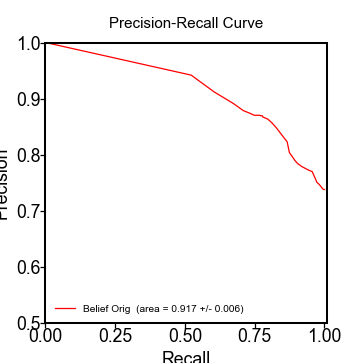

(0.5, 1)

In [51]:
fig = plot_prc(no_wt_bel)
ax = fig.gca()
ax.set_ylim([0.5, 1])

<IPython.core.display.Javascript object>


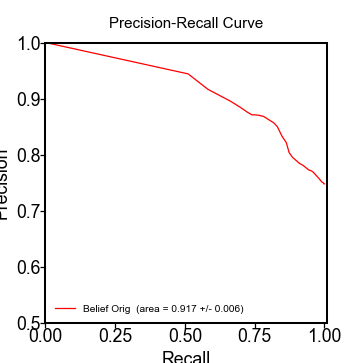

(0.5, 1)

In [52]:
fig = plot_prc(supp_no_wt_bel)
ax = fig.gca()
ax.set_ylim([0.5, 1])

<IPython.core.display.Javascript object>


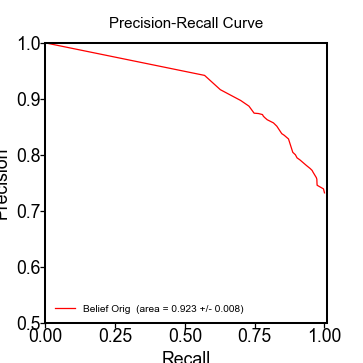

(0.5, 1)

In [61]:
fig = plot_prc(supp_no_wt_bel_dbs)
ax = fig.gca()
ax.set_ylim([0.5, 1])

## Summarize results for Table 6

In [62]:
model_results_list = [
  (no_wt, 'readers'),
  (no_wt_bel, 'readers'),
  (no_wt_more_feats, 'readers'),
  (supp_no_wt, 'readers, specific'),
  (supp_no_wt_bel, 'readers, specific'),
  (supp_no_wt_more_feats, 'readers, specific'),
  (no_wt_dbs, 'all sources'),
  (no_wt_more_feats_dbs, 'all sources'),
  (supp_no_wt_dbs, 'all sources, specific'),
  (supp_no_wt_bel_dbs, 'all sources, specific'),
  (supp_no_wt_more_feats_dbs, 'all sources, specific'),
]
model_results = {}
for results_dict, suffix in model_results_list:
    for model_condition, results_obj in results_dict.items():
        model_key = f'{model_condition.strip()} - {suffix}'
        model_results[model_key] = results_obj

In [63]:
table6_order = [
    'Belief Orig - readers',
    'RF 2k-d13 - readers',
    'Log LR - readers',
    'KNN - readers',
    'SVC - readers',
    'RF 2k-d13 + Type/#PMIDs - readers',
    'RF 2k-d13 + Type/#PMIDs/avglen - readers',
    'RF 2k-d13 + Type/#PMIDs/promoter - readers',
    'RF 2k-d13 + Type/#PMIDs/prom/avglen - readers',
    'Log LR + Type/#PMIDs - readers',
    'Log LR + Type/#PMIDs/avglen - readers',
    'Log LR + Type/#PMIDs/promoter - readers',
    'Log LR + Type/#PMIDs/prom/avglen - readers',
    'KNN + Type/#PMIDs - readers',
    'SVC + Type/#PMIDs - readers',
    'Belief Orig - readers, specific',
    'RF 2k-d13 - readers, specific',
    'Log LR - readers, specific',
    'KNN - readers, specific',
    'SVC - readers, specific',
    'RF 2k-d13 + Type/#PMIDs - readers, specific',
    'RF 2k-d13 + Type/#PMIDs/avglen - readers, specific',
    'RF 2k-d13 + Type/#PMIDs/promoter - readers, specific',
    'RF 2k-d13 + Type/#PMIDs/prom/avglen - readers, specific',
    'Log LR + Type/#PMIDs - readers, specific',
    'Log LR + Type/#PMIDs/avglen - readers, specific',
    'Log LR + Type/#PMIDs/promoter - readers, specific',
    'Log LR + Type/#PMIDs/prom/avglen - readers, specific',
    'KNN + Type/#PMIDs - readers, specific',
    'SVC + Type/#PMIDs - readers, specific',
    'Belief Orig - all sources, specific',
    'RF 2k-d13 - all sources, specific',
    'RF 2k-d13 + Type/#PMIDs - all sources, specific',
    'RF 2k-d13 + Type/#PMIDs/avglen - all sources, specific',
    'RF 2k-d13 + Type/#PMIDs/promoter - all sources, specific',
    'RF 2k-d13 + Type/#PMIDs/prom/avglen - all sources, specific',
    'Log LR - all sources, specific',
    'Log LR + Type/#PMIDs - all sources, specific',
    'Log LR + Type/#PMIDs/avglen - all sources, specific',
    'Log LR + Type/#PMIDs/promoter - all sources, specific',
    'Log LR + Type/#PMIDs/prom/avglen - all sources, specific',  
]

# Other results not included in Table 6
other_results = [
    'RF 2k-d13 - all sources',
    'RF 2k-d13 + Type/#PMIDs - all sources',
    'RF 2k-d13 + Type/#PMIDs/avglen - all sources',
    'RF 2k-d13 + Type/#PMIDs/promoter - all sources',
    'RF 2k-d13 + Type/#PMIDs/prom/avglen - all sources',
    'Log LR - all sources',
    'Log LR + Type/#PMIDs - all sources',
    'Log LR + Type/#PMIDs/avglen - all sources',
    'Log LR + Type/#PMIDs/promoter - all sources',
    'Log LR + Type/#PMIDs/prom/avglen - all sources',
    'SVC - all sources',
    'SVC + Type/#PMIDs - all sources',
    'KNN - all sources',
    'KNN + Type/#PMIDs - all sources',
    'SVC - all sources, specific',
    'SVC + Type/#PMIDs - all sources, specific',
    'KNN - all sources, specific',
    'KNN + Type/#PMIDs - all sources, specific',
]

In [64]:
# Print all results in a table
table6_rows = [['Row', 'Model', 'AUPRC']]
for ix, model_key in enumerate(table6_order):
    result_obj = model_results[model_key]
    pr_aucs = result_obj.get_summary()['pr_auc']
    auc_mean = np.mean(pr_aucs)
    auc_sd = np.std(pr_aucs)
    row = [ix + 1, model_key, f'{round(auc_mean,3)} +/- {round(auc_sd, 3)}']
    table6_rows.append(row)

table6 = texttable.Texttable()
table6.add_rows(table6_rows)
print(table6.draw())

+-----+------------------------------------------------------+-----------------+
| Row |                        Model                         |      AUPRC      |
+=====+======================================================+=================+
| 1   | Belief Orig - readers                                | 0.917 +/- 0.019 |
+-----+------------------------------------------------------+-----------------+
| 2   | RF 2k-d13 - readers                                  | 0.893 +/- 0.019 |
+-----+------------------------------------------------------+-----------------+
| 3   | Log LR - readers                                     | 0.91 +/- 0.018  |
+-----+------------------------------------------------------+-----------------+
| 4   | KNN - readers                                        | 0.9 +/- 0.017   |
+-----+------------------------------------------------------+-----------------+
| 5   | SVC - readers                                        | 0.891 +/- 0.014 |
+-----+---------------------

In [65]:
# Print other results not included in Table 6 (for length reasons)
other_results_rows = [['Row', 'Model', 'AUPRC']]
for ix, model_key in enumerate(other_results):
    result_obj = model_results[model_key]
    pr_aucs = result_obj.get_summary()['pr_auc']
    auc_mean = np.mean(pr_aucs)
    auc_sd = np.std(pr_aucs)
    row = [ix + 1, model_key, f'{round(auc_mean, 3)} +/- {round(auc_sd, 3)}']
    other_results_rows.append(row)

other_results_table = texttable.Texttable()
other_results_table.add_rows(other_results_rows)
print(other_results_table.draw())

+-----+---------------------------------------------------+-----------------+
| Row |                       Model                       |      AUPRC      |
+=====+===================================================+=================+
| 1   | RF 2k-d13 - all sources                           | 0.905 +/- 0.018 |
+-----+---------------------------------------------------+-----------------+
| 2   | RF 2k-d13 + Type/#PMIDs - all sources             | 0.928 +/- 0.019 |
+-----+---------------------------------------------------+-----------------+
| 3   | RF 2k-d13 + Type/#PMIDs/avglen - all sources      | 0.929 +/- 0.018 |
+-----+---------------------------------------------------+-----------------+
| 4   | RF 2k-d13 + Type/#PMIDs/promoter - all sources    | 0.936 +/- 0.018 |
+-----+---------------------------------------------------+-----------------+
| 5   | RF 2k-d13 + Type/#PMIDs/prom/avglen - all sources | 0.938 +/- 0.018 |
+-----+---------------------------------------------------+-----